In [135]:
class NetworkHelper:
    def __init__(self, time):
        self.time = time
        self.sending = False
        self.sending_dst = 0
        self.sending_message = ""

    def hello_world(self):
        print("hello world from networkHelper")

    def add_time(self):
        self.time += 1

    def send(self, dst, message):
        self.sending = True
        self.sending_dst = dst
        self.sending_message = message


class NetworkSimHub:
    def __init__(self, child_num, time, NetworkHelper):
        self.child_num = child_num
        self.time = time
        self.networkHelper = NetworkHelper


    def hello_world(self):
        print("hello world")
        self.networkHelper.hello_world()
    
    def send(self, dst , message):
        self.networkHelper.send(dst, message)
    
    def add_time(self):
        self.time += 1


class NetworkSimChild:
    
    def __init__(self, id, time, NetworkHelper):
        self.id = id
        self.sleeping = False
        self.time = time
        self.networkHelper = NetworkHelper

    def hello_world(self):
        print("hello world")
    
    def add_time(self):
        self.time += 1
        


nsHelper = NetworkHelper(0)
ns0 = NetworkSimHub(1,0,nsHelper)
ns1 = NetworkSimChild(1,0,nsHelper)
for i in range(10):
    nsHelper.add_time()
    ns0.add_time()
    ns1.add_time()
    print(nsHelper.time, ns0.time, ns1.time)

1 1 1
2 2 2
3 3 3
4 4 4
5 5 5
6 6 6
7 7 7
8 8 8
9 9 9
10 10 10


In [136]:
class NetworkSimHub:
    def __init__(self, child_num, time):
        self.child_num = child_num
        self.time = time
        self.receivedMessage = ""

    def send(self, dst, message):
        dst.receivedMessage = message
        print("sent: "+ str(message))
    
    def add_time(self, time):
        self.time += time

    def check_message(self):
        print("received: "+ str(self.receivedMessage))

class NetworkSimChild:
    def __init__(self, id, time):
        self.id = id
        self.sleeping = False
        self.time = time
        self.receivedMessage = ""

    def send(self, dst, message):
        dst.receivedMessage = message
        print("sent: "+ str(message))

    def add_time(self, time):
        self.time += time

    def check_message(self):
        print("received: "+ str(self.receivedMessage))
    
    def respond_with_data(self, dst):
        if self.receivedMessage!="":
            self.send(dst, "hello from "+str(self.id))

        
ns0 = NetworkSimHub(1,0)
ns1 = NetworkSimChild(1,0)

for i in range(10):
    ns0.add_time(0.1)
    ns1.add_time(0.1)
    print(ns0.time, ns1.time)
    if i == 3:
        ns0.send(ns1,"hello")
        ns0.add_time(0.3)
        ns1.add_time(0.3)
    ns0.check_message()
    ns1.check_message()

0.1 0.1
received: 
received: 
0.2 0.2
received: 
received: 
0.30000000000000004 0.30000000000000004
received: 
received: 
0.4 0.4
sent: hello
received: 
received: hello
0.7999999999999999 0.7999999999999999
received: 
received: hello
0.8999999999999999 0.8999999999999999
received: 
received: hello
0.9999999999999999 0.9999999999999999
received: 
received: hello
1.0999999999999999 1.0999999999999999
received: 
received: hello
1.2 1.2
received: 
received: hello
1.3 1.3
received: 
received: hello


In [37]:
time = 0
alive = [True, False]
print("time: "+str(time))
for _ in range(2):
    print("wake up repeat")
    print("sending base->repeat")
    time = round(time+1,2)
    print("time: "+str(time))

    for child_id in range(2):
        print("wake up "+str(child_id)+", wait for time error")
        time = round(time+1,2)
        print("t: "+str(time))

        # repeat->end
        print("sending repeat->"+str(child_id))
        time = round(time+1,2)
        print("t: "+str(time))
        
        if alive[child_id]:
            # end->repeat
            print("sending "+str(child_id)+"->repeat")
            time = round(time+1,2)
            print("t: "+str(time))
        else:
            # timeout
            print(str(child_id)+" is dead, timeout")
            time = round(time+3,2)
            print("t: "+str(time))
    print()
    
    

time: 0
wake up repeat
sending base->repeat
time: 1
wake up 0, wait for time error
t: 2
sending repeat->0
t: 3
sending 0->repeat
t: 4
wake up 1, wait for time error
t: 5
sending repeat->1
t: 6
1 is dead, timeout
t: 9

wake up repeat
sending base->repeat
time: 10
wake up 0, wait for time error
t: 11
sending repeat->0
t: 12
sending 0->repeat
t: 13
wake up 1, wait for time error
t: 14
sending repeat->1
t: 15
1 is dead, timeout
t: 18



rssiの値によって次に送る順番を変える方式


みんな起きる
前のrssiの値から順番を作ってbroadcastで送る　（ここはackがないから失敗したノードはrequestが来るまで起き続けることになる）
順番に従って必要な分スリープする
request方式で送る
みんなスリープする

example
0
hub -> repeat
1
repeat -> end1
2
end1 -> repeat
3
repeat -> end2
4
repeat -> end2
5
end2 -> repeat
6

repeat 0~6
end1 1~3
end2 3~6

In [222]:
import random
ontimes_child = []
ontimes_repeat = []
success_rate_array = []
# endとrepeatの通信は最小でsend_delay、最大でtimeout
child_num = 10
simulation_num = 100
time_span = 600
max_retry = 5
# retry_p = 0.01
retry_sum = 0
send_delay = 1
send_timeout_delay = 3
# time_error_wait_time = 1
for retry_p in [num * 0.01 for num in range(0, 101)]:
    time = 0
    success_rate = 0

    alive = [True]*child_num
    ontime = [0]*(child_num+1)
    wakeup_time = [0]*(child_num+1)
    for i in range(1,child_num+1):
        # wakeup_time[i] = send_delay*2*i-time_error_wait_time 
        # wakes up at this time on their clock, but in reality it's send_delay*2*i
        # because the time is delayed due to sending delay
        wakeup_time[i] = send_delay*2*i - send_delay


    for _ in range(simulation_num):

        time = round(time+1,2)

        for child_id in range(child_num):
            if alive[child_id]:
                # repeat->end
                retry_num = 0
                # get retry count
                for i in range(max_retry):
                    if random.random()>retry_p:
                        break
                    else:
                        retry_num += 1
                
                # add time
                retry_sum += retry_num
                time = round(time+send_delay*(1+retry_num),2)
            
                if retry_num == max_retry and random.random()<=retry_p:
                    # communication failed
                    pass
                else:
                    # end->repeat
                    retry_num = 0
                    # get retry count
                    for i in range(max_retry):
                        if random.random()>retry_p:
                            break
                        else:
                            retry_num += 1

                    # add time
                    retry_sum += retry_num 
                    time = round(time+send_delay*(1+retry_num),2)
                    if retry_num == max_retry and random.random()<=retry_p:
                        pass
                    else:
                        success_rate += 1
                # add ontime the time on
                ontime[child_id+1] += (time%time_span-wakeup_time[child_id+1])
                # print(time,wakeup_time[child_id+1])
                if time%time_span-wakeup_time[child_id+1] <=0:
                    print("warning")

            else:
                # timeout
                time = round(time+send_timeout_delay,2)

        ontime[0] += (time%time_span-wakeup_time[0])

        time = round(time+(time_span-time%time_span),2)


    for i in range(len(ontime)):
        ontime[i] /= simulation_num

    ontimes_child.append(sum(ontime[1:])/child_num)
    ontimes_repeat.append(ontime[0])
    success_rate_array.append(success_rate/(simulation_num*child_num))
print(ontimes_child)

ontimes_repeat_request = ontimes_repeat
ontimes_child_request = ontimes_child
success_rate_array_request = success_rate_array

[2.0, 2.0620000000000003, 2.162, 2.3609999999999998, 2.489, 2.665, 2.718, 2.896, 2.958, 3.0919999999999996, 3.357, 3.4810000000000003, 3.3989999999999996, 3.4550000000000005, 3.96, 3.711, 4.109, 4.414, 4.671000000000001, 4.6049999999999995, 4.691999999999999, 4.871, 5.272, 5.517, 5.679, 5.7379999999999995, 5.681, 5.901, 5.993, 6.654999999999999, 6.747999999999999, 7.061, 7.206, 7.233000000000001, 7.756, 7.7170000000000005, 8.086, 8.419999999999998, 8.487, 8.831, 9.184000000000001, 9.412, 9.745000000000001, 10.163, 10.735, 10.723, 11.008, 11.707, 11.728, 11.951, 12.003000000000002, 12.936000000000002, 12.684000000000001, 13.261000000000001, 14.031, 14.251000000000001, 14.483, 15.26, 15.701000000000002, 16.424, 16.693, 17.095999999999997, 17.208, 17.764999999999997, 18.362000000000002, 18.972, 19.866000000000003, 18.384999999999998, 20.574, 20.933, 22.01, 21.993000000000002, 22.256, 22.594, 23.02, 24.324, 24.071999999999996, 25.594, 25.149, 26.404000000000003, 25.336000000000002, 27.151,

child_num: 10
simulation_num: 100
time_span: 600
send_delay: 1
time_span: 600
repeat on time


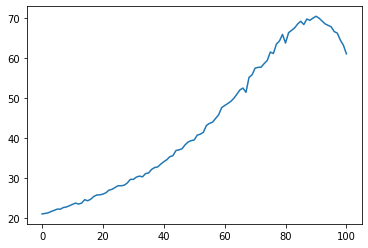

child average on time


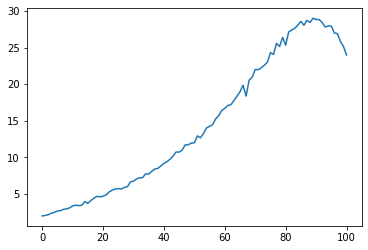

success rate for repeat <-> child


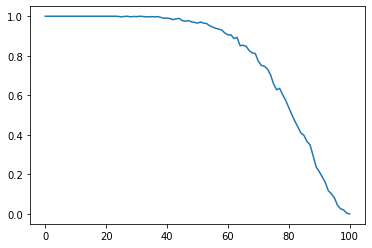

In [223]:
import matplotlib.pyplot as plt
print("child_num: "+str(child_num))
print("simulation_num: "+str(simulation_num))
print("time_span: "+str(time_span))
print("send_delay: "+str(send_delay))
print("time_span: "+str(time_span))

print("repeat on time")
plt.plot(ontimes_repeat)
plt.show()
print("child average on time")
plt.plot(ontimes_child)
plt.show()
print("success rate for repeat <-> child")
plt.plot(success_rate_array)
plt.show()


example

0
hub -> repeat
1
repeat -> all end
2
end1 -> repeat
3
(end1 -> repeat)
4
(end1 -> repeat)
5
end2 -> repeat
6
end2 -> repeat
7
(end2 -> repeat)
8

repeat 0~8
end1 1~3
end2 1, 3~6

In [233]:
import random
ontimes_child = []
ontimes_repeat = []
success_rate_array = []
# endとrepeatの通信は最小でsend_delay、最大でtimeout
child_num = 10
simulation_num = 10000
time_span = 600
max_retry = 5
# retry_p = 0.01
retry_sum = 0
send_delay = 1
send_timeout_delay = 3
# time_error_wait_time = 1
for retry_p in [num * 0.01 for num in range(0, 101)]: # 0,101
    time = 0
    success_rate = 0

    alive = [True]*child_num
    ontime = [0]*(child_num+1)
    wakeup_time = [0]*(child_num+1)
    for i in range(1,child_num+1):
        # wakeup_time[i] = send_delay*2*i-time_error_wait_time 
        # wakes up at this time on their clock, but in reality it's send_delay*2*i
        # because the time is delayed due to sending delay
        wakeup_time[i] = send_delay*2 + send_delay*(1+max_retry)*(i-1)

    for _ in range(simulation_num):

        time = round(time+send_delay*2,2)

        for child_id in range(child_num):
            if alive[child_id]:
                # end->repeat
                retry_num = 0
                # get retry count
                for i in range(max_retry):
                    if random.random()>retry_p:
                        break
                    else:
                        retry_num += 1
                
                # add time
                retry_sum += retry_num
                time = round(time+send_delay*(1+retry_num),2)
            
                if retry_num == max_retry and random.random()<=retry_p:
                    # communication failed
                    pass
                else:
                    success_rate += 1

                # add ontime the time on
                ontime[child_id+1] += (time%time_span-wakeup_time[child_id+1]) + send_delay # add the time to receive now time
                # print(time,wakeup_time[child_id+1])
                if time%time_span-wakeup_time[child_id+1] <=0:
                    print("warning")
                
                time = round(time+send_delay*(max_retry-retry_num),2)

            else:
                # timeout
                time = round(time+send_timeout_delay,2)

        ontime[0] += (time%time_span-wakeup_time[0])

        time = round(time+(time_span-time%time_span),2)


    for i in range(len(ontime)):
        ontime[i] /= simulation_num
    ontimes_child.append(sum(ontime[1:])/child_num)
    ontimes_repeat.append(ontime[0])
    success_rate_array.append(success_rate/(simulation_num*child_num))
print(ontimes_child)

ontimes_repeat_timeslot = ontimes_repeat
ontimes_child_timeslot = ontimes_child
success_rate_array_timeslot = success_rate_array


[2.0, 2.0106100000000002, 2.0202799999999996, 2.03009, 2.04172, 2.05375, 2.06417, 2.0741799999999997, 2.08758, 2.1000900000000002, 2.10973, 2.12188, 2.13614, 2.14741, 2.16112, 2.1779, 2.1925699999999995, 2.20673, 2.2198499999999997, 2.23356, 2.24793, 2.26585, 2.28287, 2.30071, 2.31422, 2.33387, 2.3529500000000003, 2.3710999999999998, 2.3888900000000004, 2.4043, 2.4243200000000003, 2.4437500000000005, 2.46896, 2.49355, 2.5057799999999997, 2.5326200000000005, 2.5592, 2.5830499999999996, 2.61282, 2.63305, 2.65968, 2.6803199999999996, 2.71288, 2.74505, 2.7786699999999995, 2.8008800000000003, 2.82946, 2.86615, 2.90044, 2.9306099999999997, 2.9659999999999997, 3.0097599999999995, 3.0515700000000003, 3.07984, 3.12061, 3.1628499999999997, 3.21412, 3.2411000000000003, 3.2862100000000005, 3.33714, 3.3862499999999995, 3.4313000000000002, 3.47832, 3.52665, 3.58617, 3.6382799999999995, 3.6946199999999996, 3.7533300000000005, 3.8087299999999997, 3.8791399999999996, 3.93703, 4.0067, 4.06846, 4.14268, 

In [1]:
plt.figure(facecolor="white")
plt.plot(ontimes_repeat_request, label="method 1")
plt.plot(ontimes_repeat_timeslot, label="method 2")
plt.legend()
plt.title("repeat on-time")
plt.xlabel("retry probability")
plt.ylabel("(s)")
plt.show()

plt.figure(facecolor="white")
plt.plot(ontimes_child_request, label="method 1")
plt.plot(ontimes_child_timeslot, label="method 2")
plt.legend()
plt.title("end average on-time")
plt.xlabel("retry probability")
plt.ylabel("(s)")
plt.show()

plt.figure(facecolor="white")
plt.plot(success_rate_array_request, label="method 1")
plt.plot(success_rate_array_timeslot, label="method 2")
plt.legend()
plt.title("success rate for repeat <-> end")
plt.xlabel("retry probability")
# plt.ylabel("(s)")
plt.show()

NameError: name 'plt' is not defined

child_num: 10
simulation_num: 100
time_span: 600
send_delay: 1
time_span: 600


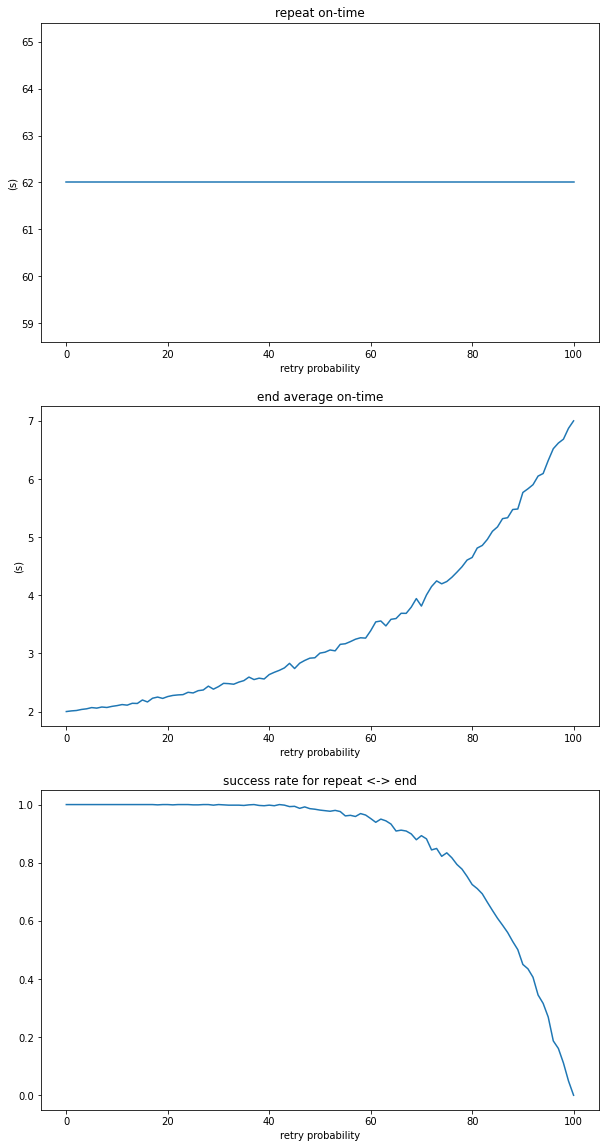

In [229]:
import matplotlib.pyplot as plt
print("child_num: "+str(child_num))
print("simulation_num: "+str(simulation_num))
print("time_span: "+str(time_span))
print("send_delay: "+str(send_delay))
print("time_span: "+str(time_span))

# print("repeat on time")
# plt.plot(ontimes_repeat)
# plt.show()
# print("child average on time")
# plt.plot(ontimes_child)
# plt.show()
# print("success rate for repeat <-> child")
# plt.plot(success_rate_array)
# plt.show()

fig = plt.figure(figsize = (10,20))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot(ontimes_repeat)
ax2.plot(ontimes_child)
ax3.plot(success_rate_array)

ax1.set_title("repeat on-time")
ax2.set_title("end average on-time")
ax3.set_title("success rate for repeat <-> end")

ax1.set_xlabel("retry probability")
ax2.set_xlabel("retry probability")
ax3.set_xlabel("retry probability")

ax1.set_ylabel("(s)")
ax2.set_ylabel("(s)")

plt.show()

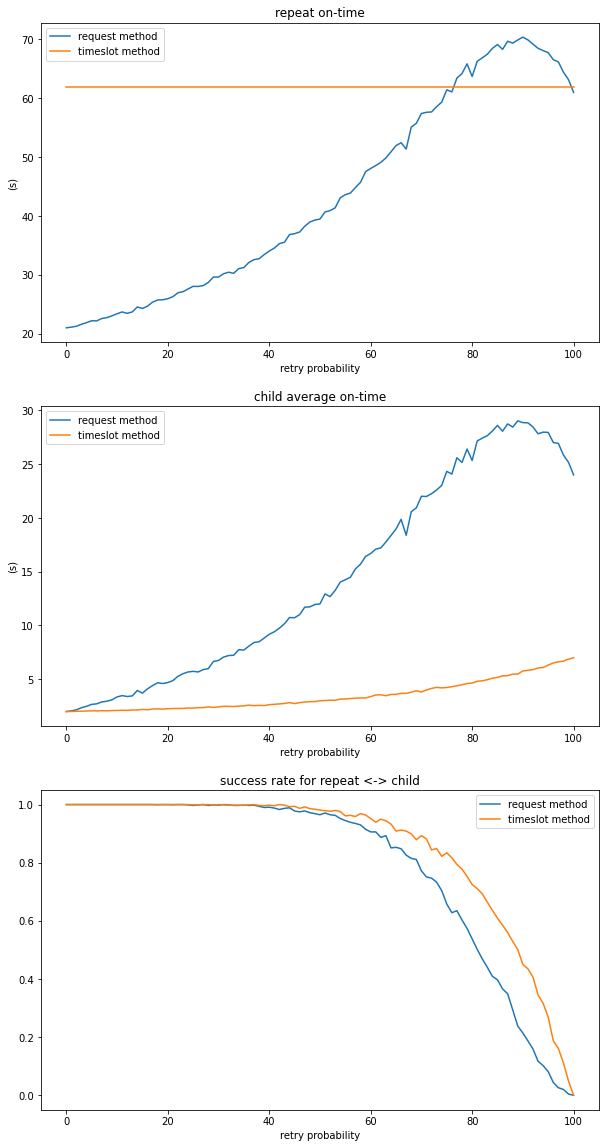

In [230]:
fig = plt.figure(figsize = (10,20))

ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

ax1.plot(ontimes_repeat_request, label="request method")
ax2.plot(ontimes_child_request, label="request method")
ax3.plot(success_rate_array_request, label="request method")

ax1.plot(ontimes_repeat_timeslot, label="timeslot method")
ax2.plot(ontimes_child_timeslot, label="timeslot method")
ax3.plot(success_rate_array_timeslot, label="timeslot method")

ax1.legend()
ax2.legend()
ax3.legend()

ax1.set_title("repeat on-time")
ax2.set_title("child average on-time")
ax3.set_title("success rate for repeat <-> child")

ax1.set_xlabel("retry probability")
ax2.set_xlabel("retry probability")
ax3.set_xlabel("retry probability")

ax1.set_ylabel("(s)")
ax2.set_ylabel("(s)")

plt.show()

you could decide max retry based on the acceptable success rate